In [14]:
import sklearn.tree as tree
import matplotlib.pyplot as plt
import pickle
import gc
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [15]:
from tester_trade_log.data_iterator import DataIterator

from ta.momentum import RSIIndicator
from tqdm import tqdm

import datetime
import pandas as pd

TRAIN_LENGTH = 199
TEST_LENGTH = 50


# всего 249 дней
# train = 80% = 199
# test = 20% = 50
def get_dfs(ticker, lengths, predict_period=10, period=datetime.timedelta(minutes=1), directory="analysis/data/tickers_trade_log"):
    data_iterator = DataIterator(directory, ticker, period)
    dfs = []
    for i, (day, (time, close, high, low, volume)) in enumerate(data_iterator):
        price = pd.Series(close)
        df = pd.DataFrame({"price_change": price.diff(periods=predict_period).shift(-predict_period)})
        df.price_change = 1 * (df.price_change > 0) + (-1) * (df.price_change < 0)
        for length in lengths:
            df[f"rsi ({length} length)"] = RSIIndicator(price, length).rsi()
        dfs.append(df[df.price_change != 0].dropna())
    return dfs


def get_X_y(df, debug=False):
    if debug:
        counts = df.price_change.value_counts()
        total_count = sum(counts)
        for i, c in zip(counts.index, counts):
            print(f"{i}:\t{c}\t({c / total_count * 100:.1f}%)")
    return df.drop(columns=["price_change"]), df.price_change

In [40]:
def get_train_test(ticker):
    lengths = [4, 7, 14]
    predict_period = 10
    dfs = get_dfs(ticker, lengths, directory="../../analysis/data/tickers_trade_log", predict_period=predict_period)
    train, test = train_test_split(dfs, train_size=TRAIN_LENGTH, shuffle=False)
    train_df = pd.concat(train, ignore_index=True)
    test_df = pd.concat(test, ignore_index=True)
    X_train, y_train = get_X_y(train_df)
    X_test, y_test = get_X_y(test_df)
    return X_train, y_train, X_test, y_test

def test_model_on_ticker(model, ticker, result_folder=None, plot=False, save=False, plot_path=""):
    X_train, y_train, X_test, y_test = get_train_test(ticker)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    if plot:
        ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, normalize="pred", cmap="CMRmap", display_labels=["Short", "Long"])
        plt.title(f"{ticker} ({score:.3f} score)")
        if plot_path:
            plt.savefig(plot_path)
        plt.show()
    if save:
        with open(os.path.join(result_folder, ticker), "wb") as f:
            pickle.dump(model, f)
    return score

def test_model_on_tickers(model, tickers, scores_file, result_folder):
    scores = []
    iterator = tqdm(tickers)
    for ticker in iterator:
        iterator.set_description(ticker)
        scores.append(test_model_on_ticker(model, ticker, result_folder))
        gc.collect()
    with open(scores_file, "w") as f:
        print(*scores, file=f)
    return scores

In [17]:
tickers = sorted([file.removesuffix(".txt") for file in os.listdir("../../analysis/data/tickers_trade_log") if file != "cache"])

In [18]:
test_model_on_tickers(tree.DecisionTreeClassifier(max_depth=2, class_weight="balanced"), tickers, "scores_tree.txt", "saved/tree", save=True)
test_model_on_tickers(RandomForestClassifier(max_depth=2, class_weight="balanced"), tickers, "scores_forest.txt", "saved/forest", save=True)

YNDX: 100%|██████████| 38/38 [06:22<00:00, 10.07s/it] 


[0.5873315239891439,
 0.5618206227534537,
 0.5501980949169687,
 0.5649505452700989,
 0.5759074990271833,
 0.5489436916084505,
 0.5876249405045216,
 0.5689691998803879,
 0.5197791330146695,
 0.5245792367938676,
 0.5386924616410941,
 0.5794436586515794,
 0.5214929321319335,
 0.5390662323561346,
 0.5403386454183267,
 0.522375539990773,
 0.6073109097246427,
 0.575,
 0.5411918795022921,
 0.5473851427615902,
 0.5405371485943775,
 0.6023388902712118,
 0.5981116950209316,
 0.5431030845183341,
 0.5626472384608673,
 0.5538167127365511,
 0.5307568703390878,
 0.5388974540605859,
 0.6286390402289362,
 0.5361240701046527,
 0.5478951348626165,
 0.6367012223425653,
 0.5274780426599749,
 0.6336561198063281,
 0.5465329755684225,
 0.5603298814488543,
 0.5449229355498935,
 0.5642487292765189]

In [19]:
# def get_model(ticker: str):
#     with open(os.path.join("saved", ticker), "rb") as f:
#        return pickle.load(f)
# tickers = os.listdir("saved")
# model = get_model("SBER")
# model.predict_proba(np.array([[1, 20, 3]]))

# lengths = [4, 7, 14]
# feature_names = [f"rsi ({length} length)" for length in lengths] + [f"rsi diff ({length} length)" for length in lengths]
# with open("tmp.txt", "w") as f:
#     for ticker in tickers:
#         print(ticker, file=f)
#         print(tree.export_text(get_model(ticker), feature_names=feature_names), file=f)

In [20]:
with open("scores_forest.txt") as f:
    forest_scores = np.array(list(map(float, f.readline().split())))
with open("scores_tree.txt") as f:
    tree_scores = np.array(list(map(float, f.readline().split())))

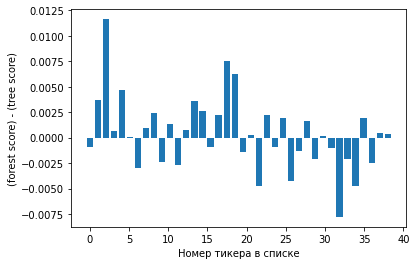

In [49]:
import numpy as np
x = np.linspace(0, len(tickers), len(tickers))
# plt.plot(x, forest_scores, label="forest_scores")
# plt.plot(x, tree_scores, label="tree_scores")
diff = forest_scores - tree_scores
plt.xlabel("Номер тикера в списке")
plt.ylabel("(forest score) - (tree score)")
plt.bar(x, diff)
plt.savefig("figures/tree-forest.png", bbox_inches='tight')
plt.show()

In [22]:
diff.mean(), diff.std()

(0.0003894640803084326, 0.0035589303399853633)

In [23]:
forest_scores.mean()

0.5605036614681007

In [24]:
tree_scores.mean()

0.5601141973877922

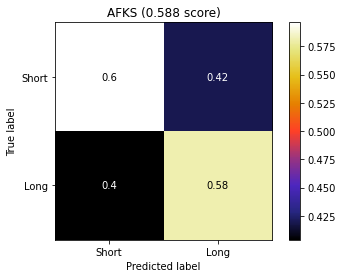

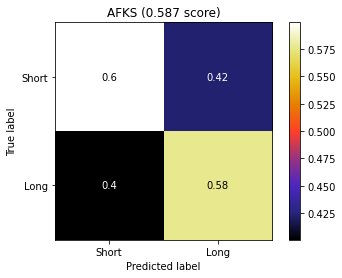

0.5872395234371406

In [45]:
test_model_on_ticker(tree.DecisionTreeClassifier(max_depth=2, class_weight="balanced"), "AFKS", save=False, plot=True, plot_path="figures/afks-tree-score.png")
test_model_on_ticker(RandomForestClassifier(max_depth=2, class_weight="balanced"), "AFKS", save=False, plot=True, plot_path="figures/afks-forest-score.png")